In [30]:
#importing necessary libraries
from api.mapbox_api_walking import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod

In [27]:
CanaryvilleCensusOverlap = pd.read_csv('../../can-summer-2023/data/extra_data/canaryvilleCensusOverlap.csv')
CanaryvilleCensusOverlap.head(1)

Unnamed: 0  Census Tract  \
0           0   17031834600   

                                            geometry  Area Within Radius  \
0  POLYGON ((-87.631568 41.791619, -87.6318705678...            0.006245   

   census Area  Percent Overlap  
0     1.562213         0.003997

In [28]:
census_demos = pd.read_csv('../../can-summer-2023/data/final_data/census_demos.csv')
census_demos.head(1)

geoid                              qualifying name  \
0  17031823303  Census Tract 8233.03, Cook County, Illinois   

                                            geometry  total population  \
0  POLYGON ((-87.720963 41.683952, -87.720304 41....              4059   

   Percent: under 5 years  Percent: 5 to 9 years  Percent: 10 to 14 years  \
0                0.047056               0.099039                 0.075634   

   Percent: 15 to 19 years  Percent: 20 to 24 years  Percent: 25 to 29 years  \
0                  0.05223                 0.040404                 0.069475   

   ...  Percent of People with Computers  Percent of People without Computers  \
0  ...                          0.912801                             0.087199   

   Percent of People with Computers and Internet  Percent: White Alone  \
0                                       0.806432              0.795763   

   Percent: Black or African American Alone  \
0                                  0.078098   

   Percent: American Indian and Alaska Native Alone  Percent: Asian Alone  \
0                                          0.009855                   0.0   

   Percent: Native Hawaiian and Other Pacific Islander Alone  \
0                                                0.0           

   Percent: Some Other Race Alone  Percent: Two or More Races  
0                        0.072924                     0.04336  

[1 rows x 94 columns]

# Merging Census Data for Canaryville 

In [23]:
#Renaming a column to 'geoid' so that it will match the internet_demos file
canaryville = CanaryvilleCensusOverlap.rename(columns={'Census Tract': 'geoid'}, inplace=True)
#Dropping unnecessary columns
canaryville = CanaryvilleCensusOverlap.drop(columns=['Unnamed: 0', 'Area Within Radius', 'census Area'], axis=1)
canaryville.head(2)

geoid                                           geometry  \
0  17031834600  POLYGON ((-87.631568 41.791619, -87.6318705678...   
1  17031612000  POLYGON ((-87.650573 41.801344, -87.6506363898...   

   Percent Overlap  
0         0.003997  
1         0.002913

In [24]:
Canaryville_merge =  census_demos.merge(canaryville, on = 'geoid')
Canaryville_merge.head(2)

geoid                           qualifying name  \
0  17031834600  Census Tract 8346, Cook County, Illinois   
1  17031612000  Census Tract 6120, Cook County, Illinois   

                                          geometry_x  total population  \
0  POLYGON ((-87.640157 41.794391, -87.640136 41....              1587   
1  POLYGON ((-87.654816 41.801454, -87.654469 41....              1208   

   Percent: under 5 years  Percent: 5 to 9 years  Percent: 10 to 14 years  \
0                0.037807               0.095778                 0.093258   
1                0.000000               0.062086                 0.091887   

   Percent: 15 to 19 years  Percent: 20 to 24 years  Percent: 25 to 29 years  \
0                 0.000000                 0.025205                 0.048519   
1                 0.086921                 0.058775                 0.058775   

   ...  Percent of People with Computers and Internet  Percent: White Alone  \
0  ...                                        0.62982              0.141777   
1  ...                                        0.62940              0.080298   

   Percent: Black or African American Alone  \
0                                  0.835539   
1                                  0.841887   

   Percent: American Indian and Alaska Native Alone  Percent: Asian Alone  \
0                                               0.0              0.000000   
1                                               0.0              0.005795   

   Percent: Native Hawaiian and Other Pacific Islander Alone  \
0                                                0.0           
1                                                0.0           

   Percent: Some Other Race Alone  Percent: Two or More Races  \
0                        0.017643                    0.005041   
1                        0.072020                    0.000000   

                                          geometry_y  Percent Overlap  
0  POLYGON ((-87.631568 41.791619, -87.6318705678...         0.003997  
1  POLYGON ((-87.650573 41.801344, -87.6506363898...         0.002913  

[2 rows x 96 columns]

- The 'geometry' column in census_demos represents the total area for each census tract.
- The 'geometry' column in altgeld represents the portion of area for each census tract that only the altgeld branch overlaps on.
- Thus, these two 'geometry' columns will not be the same values. So, since we are only looking for overlap, we can remove the 'geometry' column from the census_demos dataframe. When merging, Python changes the census_demos 'geometry' to 'geometry_x' and altgeld's 'geometry' to 'geometry_y'.

In [9]:
#Dropping geometry_x and renaming geometry_y as just geometry
canaryville_merge_changes = Canaryville_merge.drop(columns=['geometry_x'], axis=1).rename(columns={'geometry_y':'geometry'})
canaryville_merge_changes.head(2)

geoid                           qualifying name  total population  \
0  17031834600  Census Tract 8346, Cook County, Illinois              1587   
1  17031612000  Census Tract 6120, Cook County, Illinois              1208   

   Percent: under 5 years  Percent: 5 to 9 years  Percent: 10 to 14 years  \
0                0.037807               0.095778                 0.093258   
1                0.000000               0.062086                 0.091887   

   Percent: 15 to 19 years  Percent: 20 to 24 years  Percent: 25 to 29 years  \
0                 0.000000                 0.025205                 0.048519   
1                 0.086921                 0.058775                 0.058775   

   Percent: 30 to 34 years  ...  \
0                  0.05482  ...   
1                  0.12500  ...   

   Percent of People with Computers and Internet  Percent: White Alone  \
0                                        0.62982              0.141777   
1                                        0.62940              0.080298   

   Percent: Black or African American Alone  \
0                                  0.835539   
1                                  0.841887   

   Percent: American Indian and Alaska Native Alone  Percent: Asian Alone  \
0                                               0.0              0.000000   
1                                               0.0              0.005795   

   Percent: Native Hawaiian and Other Pacific Islander Alone  \
0                                                0.0           
1                                                0.0           

   Percent: Some Other Race Alone  Percent: Two or More Races  \
0                        0.017643                    0.005041   
1                        0.072020                    0.000000   

                                            geometry  Percent Overlap  
0  POLYGON ((-87.631568 41.791619, -87.6318705678...         0.003997  
1  POLYGON ((-87.650573 41.801344, -87.6506363898...         0.002913  

[2 rows x 95 columns]

## Age Census Data for Canaryville 

Options to Input as DemographicsVariables
- Percent: under 5 years
- Percent: 5 to 9 years	
- Percent: 10 to 14 years	
- Percent: 15 to 19 years	
- Percent: 20 to 24 years	
- Percent: 25 to 29 years	
- Percent: 30 to 34 years	
-  Percent: 35 to 39 years	
 - Percent: 50 to 54 years	
- Percent: 55 to 59 years	
 - Percent: 60 to 64 years	
- Percent: 65 to 69 years	
- Percent: 70 to 74 years	
- Percent: 75 to 79 years	
- Percent: 80 to 84 years	
- Percent: 85 years and over

We want to only look at the age census information for the Canaryville branch. We need to extract only the age census information from the census_demos dataset that includes ALL of the census information.

In [10]:
def Age_by_branch(DemographicsVariables):
    """ This function takes the population of each variables and devide it by the population to give us the perecntage of how many people have a specific age in the overlapping area of the branch"""
    print(DemographicsVariables)
    pop_in_branch = (canaryville_merge_changes['Percent Overlap']  * canaryville_merge_changes['total population']).sum()
    Branch_pop_Var = (canaryville_merge_changes['Percent Overlap'] * canaryville_merge_changes[DemographicsVariables] * canaryville_merge_changes['total population']).sum()
    result = Branch_pop_Var/pop_in_branch
    return result

In [11]:
Age_by_branch('Percent: 20 to 24 years')

Percent: 20 to 24 years


0.07296921502242615

In [12]:
Age_by_branch('Percent: 75 to 79 years')

Percent: 75 to 79 years


0.022445654240078196

## Race Census Data for Canaryville 

Options to Input as DemographicsVariables
- Percent: White Alone	
- Percent: Black or African American Alone	
- Percent: American Indian and Alaska Native Alone	
- Percent: Asian Alone	
- Percent: Native Hawaiian and Other Pacific Islander Alone	Percent: Some Other Race Alone	
- Percent: Two or More Races

We want to only look at the Race census information for the Canaryville branch. We need to extract only the Race census information from the census_demos dataset that includes ALL of the census information.

In [13]:
def Race_by_branch(DemographicsVariables):
    """ This function takes the population of each variables and devide it by the population to give us the perecntage of how many people have a specific Race in the overlapping area of the branch"""
    print(DemographicsVariables)
    pop_in_branch = (canaryville_merge_changes['Percent Overlap']  * canaryville_merge_changes['total population']).sum()
    Branch_pop_Var = (canaryville_merge_changes['Percent Overlap'] * canaryville_merge_changes[DemographicsVariables] * canaryville_merge_changes['total population']).sum()
    result = Branch_pop_Var/pop_in_branch
    return result

In [14]:
Race_by_branch('Percent: American Indian and Alaska Native Alone')

Percent: American Indian and Alaska Native Alone


0.004288959474773459

In [15]:
Race_by_branch('Percent: Two or More Races')

Percent: Two or More Races


0.06923747596420475

## Education Census Data for Canaryville 

Options to Input as DemographicsVariables
- Percent: 25+ Less Than High School	
- Percent: 25+ High School or More	
- Percent: 25+ Some College or More	Percent: 25+ Bachelor's Degree or More	
- Percent: 25+ Master's Degree or More	
- Percent: 25+ Professional School Degree or More	
- Percent: 25+ Doctorate Degree

In [16]:
def Education_by_branch(DemographicsVariables):
    """ This function takes the population of each variables and devide it by the population to give us the perecntage of how many people have a specific degree in the overlapping area of the branch"""
    print(DemographicsVariables)
    pop_in_branch = (canaryville_merge_changes['Percent Overlap']  * canaryville_merge_changes['population 25 years and over']).sum()
    Branch_pop_Var = (canaryville_merge_changes['Percent Overlap'] * canaryville_merge_changes[DemographicsVariables] * canaryville_merge_changes['population 25 years and over']).sum()
    result = Branch_pop_Var/pop_in_branch
    return result

In [51]:
Education_by_branch('Percent: 25+ High School or More')

Percent: 25+ High School or More


0.8252115373717146

In [19]:
Education_by_branch('Percent: 25+ Master\'s Degree or More')

Percent: 25+ Master's Degree or More


0.10865964360158936

In [20]:
Education_by_branch('Percent: 25+ Doctorate Degree')

Percent: 25+ Doctorate Degree


0.015179915325744756

## Commute Census Data for Canaryville

We want to only look at the commute census information for the Canary branch. We need to extract only the commute census information from the census_demos dataset that includes ALL of the census information.

Possible Variables that can be used for 'DemographicsVariables':

- Percent Owner and Renter Occupied Housing: No Vehicles
- Percent Owner and Renter Occupied Housing: 1 Vehicle
- Percent Owner and Renter Occupied Housing: 2 Vehicles
- Percent Owner and Renter Occupied Housing: 3 Vehicles
- Percent Owner and Renter Occupied Housing: 4 Vehicles
- Percent Owner and Renter Occupied Housing: 5 or More Vehicles
- Percent Renter-Occupied Housing: No Vehicles
- Percent Renter-Occupied Housing: 1 Vehicle
- Percent Renter-Occupied Housing: 2 Vehicles
- Percent Renter-Occupied Housing: 3 Vehicles
- Percent Renter-Occupied Housing: 4 Vehicles
- Percent Renter-Occupied Housing: 5 or More Vehicles
- Percent Workers 16+: Car, Truck, or Van
- Percent Workers 16+: Drove Alone
- Percent Workers 16+: Carpooled
- Percent Workers 16+: Public Transportation (Includes Taxi)
- Percent Workers 16+: Motorcycle
- Percent Workers 16+: Bicycle
- Percent Workers 16+: Walked
- Percent Workers 16+: Other Means

*To get a percentage, you write: commute_by_branch('your pick from above')

In [21]:
def commute_by_branch(DemographicsVariables):
    if DemographicsVariables == 'Percent Owner and Renter Occupied Housing: No Vehicles' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 1 Vehicle' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 2 Vehicles' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 3 Vehicles' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 4 Vehicles' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 5 or More Vehicles':
        print(DemographicsVariables)
        pop_in_branch = (canaryville_merge_changes['Percent Overlap']  * canaryville_merge_changes['occupied housing units']).sum()
        Branch_pop_withCommute = (canaryville_merge_changes['Percent Overlap'] * canaryville_merge_changes[DemographicsVariables] * canaryville_merge_changes['occupied housing units']).sum() 
        result = Branch_pop_withCommute/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Renter-Occupied Housing: No Vehicles' or DemographicsVariables == 'Percent Renter-Occupied Housing: 1 Vehicle' or DemographicsVariables == 'Percent Renter-Occupied Housing: 2 Vehicles' or DemographicsVariables == 'Percent Renter-Occupied Housing: 3 Vehicles' or DemographicsVariables == 'Percent Renter-Occupied Housing: 4 Vehicles' or DemographicsVariables == 'Percent Renter-Occupied Housing: 5 or More Vehicles':
        print(DemographicsVariables)
        pop_in_branch = (canaryville_merge_changes['Percent Overlap']  * canaryville_merge_changes['renter-occupied housing units']).sum()
        Branch_pop_withCommute = (canaryville_merge_changes['Percent Overlap'] * canaryville_merge_changes[DemographicsVariables] * canaryville_merge_changes['renter-occupied housing units']).sum() 
        result = Branch_pop_withCommute/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Workers 16+: Car, Truck, or Van ' or DemographicsVariables == 'Percent Workers 16+: Drove Alone' or DemographicsVariables == 'Percent Workers 16+: Carpooled' or DemographicsVariables == 'Percent Workers 16+: Public Transportation (Includes Taxi)' or DemographicsVariables == 'Percent Workers 16+: Motorcycle' or DemographicsVariables == 'Percent Workers 16+: Bicycle' or DemographicsVariables == 'Percent Workers 16+: Walked' or DemographicsVariables == 'Percent Workers 16+: Other Means':
        print(DemographicsVariables)
        pop_in_branch = (canaryville_merge_changes['Percent Overlap']  * canaryville_merge_changes['workers 16 years and over']).sum()
        Branch_pop_withCommute = (canaryville_merge_changes['Percent Overlap'] * canaryville_merge_changes[DemographicsVariables] * canaryville_merge_changes['workers 16 years and over']).sum() 
        result = Branch_pop_withCommute/pop_in_branch
        return result

### Examples of inputs -- checking work

In [22]:
commute_by_branch('Percent Owner and Renter Occupied Housing: No Vehicles')

Percent Owner and Renter Occupied Housing: No Vehicles


0.27565592560333224

In [23]:
commute_by_branch('Percent Owner and Renter Occupied Housing: 1 Vehicle')

Percent Owner and Renter Occupied Housing: 1 Vehicle


0.43166041574223346

In [24]:
commute_by_branch('Percent Owner and Renter Occupied Housing: 2 Vehicles')

Percent Owner and Renter Occupied Housing: 2 Vehicles


0.23197156080657513

In [25]:
commute_by_branch('Percent Owner and Renter Occupied Housing: 3 Vehicles')

Percent Owner and Renter Occupied Housing: 3 Vehicles


0.039785879098000805

In [26]:
commute_by_branch('Percent Workers 16+: Public Transportation (Includes Taxi)')

Percent Workers 16+: Public Transportation (Includes Taxi)


0.2093437444361977

In [27]:
commute_by_branch('Percent Workers 16+: Bicycle')

Percent Workers 16+: Bicycle


0.012428811826687817

In [28]:
commute_by_branch('Percent Workers 16+: Car, Truck, or Van ')

Percent Workers 16+: Car, Truck, or Van 


0.651354213522267

## Income Census Data for Canaryville 


We want to only look at the income census information for the canaryville branch. We need to extract only the income census information from the census_demos dataset that includes ALL of the census information.

Possible Variables that can be used for 'DemographicsVariables':

- Percent Population in Labor Force 16+: Employed

- Percent Population in Labor Force 16+: Unemployed

- Percent Households: Less Than $10,000

- Percent Households: $10,000 to $14,999

- Percent Households: $15,000 to $19,999

- Percent Households: $20,000 to $24,999

- Percent Households: $25,000 to $29,999

- Percent Households: $30,000 to $34,999

- Percent Households: $35,000 to $39,999

- Percent Households: $40,000 to $44,999

- Percent Households: $45,000 to $49,999

- Percent Households: $50,000 to $59,999

- Percent Households: $60,000 to $74,999

- Percent Households: $75,000 to $99,999

- Percent Households: $100,000 to $124,999

- Percent Households: $125,000 to $149,999

- Percent Households: $150,000 to $199,999

- Percent Households: $200,000 or more

- Percent Ages 18-64: Living in Poverty

- Percent Ages 18-64: At or Above Poverty Level

- Percent Households: With Public Assistance Income

- Percent Households: No Public Assistance Income


*To get a percentage, you write: income_by_branch('your pick from above')



In [29]:
def income_by_branch(DemographicsVariables):
    if DemographicsVariables == 'Percent Population in Labor Force 16+: Employed' or DemographicsVariables == 'Percent Population in Labor Force 16+: Unemployed':
        print(DemographicsVariables)
        pop_in_branch = (canaryville_merge_changes['Percent Overlap']  * canaryville_merge_changes['civilian population in labor force 16 years and over']).sum()
        Branch_pop_withIncome = (canaryville_merge_changes['Percent Overlap'] * canaryville_merge_changes[DemographicsVariables] * canaryville_merge_changes['civilian population in labor force 16 years and over']).sum() 
        result = Branch_pop_withIncome/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Households: Less Than $10,000' or DemographicsVariables == 'Percent Households: $10,000 to $14,999' or DemographicsVariables == 'Percent Households: $15,000 to $19,999' or DemographicsVariables == 'Percent Households: $20,000 to $24,999' or DemographicsVariables == 'Percent Households: $25,000 to $29,999' or DemographicsVariables == 'Percent Households: $30,000 to $34,999' or DemographicsVariables == 'Percent Households: $35,000 to $39,999' or DemographicsVariables == 'Percent Households: $40,000 to $44,999' or DemographicsVariables == 'Percent Households: $45,000 to $49,999' or DemographicsVariables == 'Percent Households: $50,000 to $59,999' or DemographicsVariables == 'Percent Households: $60,000 to $74,999' or DemographicsVariables == 'Percent Households: $75,000 to $99,999' or DemographicsVariables == 'Percent Households: $100,000 to $124,999' or DemographicsVariables == 'Percent Households: $125,000 to $149,999' or DemographicsVariables == 'Percent Households: $150,000 to $199,999' or DemographicsVariables == 'Percent Households: $200,000 or more':
        print(DemographicsVariables)
        pop_in_branch = (canaryville_merge_changes['Percent Overlap']  * canaryville_merge_changes['total households reporting income']).sum()
        Branch_pop_withIncome = (canaryville_merge_changes['Percent Overlap'] * canaryville_merge_changes[DemographicsVariables] * canaryville_merge_changes['total households reporting income']).sum() 
        result = Branch_pop_withIncome/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Ages 18-64: Living in Poverty' or DemographicsVariables == 'Percent Ages 18-64: At or Above Poverty Level':
        print(DemographicsVariables)
        pop_in_branch = (canaryville_merge_changes['Percent Overlap']  * canaryville_merge_changes['population age 18 to 64 for whom poverty status  is determined']).sum()
        Branch_pop_withIncome = (canaryville_merge_changes['Percent Overlap'] * canaryville_merge_changes[DemographicsVariables] * canaryville_merge_changes['population age 18 to 64 for whom poverty status  is determined']).sum() 
        result = Branch_pop_withIncome/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Households: With Public Assistance Income' or DemographicsVariables == 'Percent Households: No Public Assistance Income':
        print(DemographicsVariables)
        pop_in_branch = (canaryville_merge_changes['Percent Overlap']  * canaryville_merge_changes['total households reporting public assistance income status']).sum()
        Branch_pop_withIncome = (canaryville_merge_changes['Percent Overlap'] * canaryville_merge_changes[DemographicsVariables] * canaryville_merge_changes['total households reporting public assistance income status']).sum() 
        result = Branch_pop_withIncome/pop_in_branch
        return result

### Examples of inputs -- checking work

In [30]:
income_by_branch('Percent Population in Labor Force 16+: Unemployed')

Percent Population in Labor Force 16+: Unemployed


0.14164649476864613

In [31]:
income_by_branch('Percent Population in Labor Force 16+: Employed')

Percent Population in Labor Force 16+: Employed


0.8583535052313539

In [32]:
income_by_branch('Percent Households: Less Than $10,000')

Percent Households: Less Than $10,000


0.137087904415486

In [33]:
income_by_branch('Percent Households: $10,000 to $14,999')

Percent Households: $10,000 to $14,999


0.08021462678170248

In [34]:
income_by_branch('Percent Households: $150,000 to $199,999')

Percent Households: $150,000 to $199,999


0.057158090020281514

In [35]:
income_by_branch('Percent Ages 18-64: Living in Poverty')

Percent Ages 18-64: Living in Poverty


0.20052048753557492

In [36]:
income_by_branch('Percent Ages 18-64: At or Above Poverty Level')

Percent Ages 18-64: At or Above Poverty Level


0.799479512464425

In [37]:
income_by_branch('Percent Households: With Public Assistance Income')

Percent Households: With Public Assistance Income


0.03705934639154096

In [38]:
income_by_branch('Percent Households: No Public Assistance Income')

Percent Households: No Public Assistance Income


0.9629406536084587

## Internet Census Data for Canaryville

We want to only look at the internet census information for the canary branch. We need to extract only the internet census information from the census_demos dataset that includes ALL of the census information.

Possible Variables that can be used for 'DemographicsVariables':

- Percent of People with Internet Access
- Percent of People without Internet Access
- Percent of People with Computers
- Percent of People without Computers
- Percent of People with Computers and Internet

*To get a percentage, you write: internet_by_branch('your pick from above')

In [39]:
def internet_by_branch(DemographicsVariables):
    ''' We are creating a function that allows me to retrieve only the internet census data, and then compare this with Altgeld'''
    pop_in_branch = (canaryville_merge_changes['Percent Overlap']  * canaryville_merge_changes['Total']).sum()
    Branch_pop_withInternet = (canaryville_merge_changes['Percent Overlap'] * canaryville_merge_changes[DemographicsVariables] * canaryville_merge_changes['Total']).sum() 
    result = Branch_pop_withInternet/pop_in_branch
    return result  

### Examples of Inputs--checking work

In [40]:
internet_by_branch('Percent of People with Internet Access')

0.8547810530726586

In [41]:
internet_by_branch('Percent of People with Computers')

0.8731117532858907

## Creating Branch Snapshot

In [42]:
branch_snapshot_df = pd.DataFrame({'Branch': ['Canaryville']})
branch_snapshot_df

Branch
0  Canaryville

In [43]:
def branch_demographics(branch_snapshot_df):
    list1 = ['Percent of People with Internet Access',
             'Percent of People without Internet Access',
             'Percent of People with Computers', 
             'Percent of People without Computers', 
             'Percent of People with Computers and Internet']
    for i in list1:
        branch_snapshot_df[i] = internet_by_branch(i)
    
    list2 = ['Percent Population in Labor Force 16+: Employed',
             'Percent Population in Labor Force 16+: Unemployed',
             'Percent Households: Less Than $10,000',
             'Percent Households: $10,000 to $14,999',
             'Percent Households: $15,000 to $19,999',
             'Percent Households: $20,000 to $24,999',
             'Percent Households: $25,000 to $29,999',
             'Percent Households: $30,000 to $34,999',
             'Percent Households: $35,000 to $39,999',
             'Percent Households: $40,000 to $44,999',
             'Percent Households: $45,000 to $49,999',
             'Percent Households: $50,000 to $59,999',
             'Percent Households: $60,000 to $74,999',
             'Percent Households: $75,000 to $99,999',
             'Percent Households: $100,000 to $124,999',
             'Percent Households: $125,000 to $149,999',
             'Percent Households: $150,000 to $199,999',
             'Percent Households: $200,000 or more',
             'Percent Ages 18-64: Living in Poverty',
             'Percent Ages 18-64: At or Above Poverty Level',
             'Percent Households: With Public Assistance Income',
             'Percent Households: No Public Assistance Income']
    for i in list2:
        branch_snapshot_df[i] = income_by_branch(i)
    
    list3 = ['Percent Owner and Renter Occupied Housing: No Vehicles',
             'Percent Owner and Renter Occupied Housing: 1 Vehicle',
             'Percent Owner and Renter Occupied Housing: 2 Vehicles',
             'Percent Owner and Renter Occupied Housing: 3 Vehicles',
             'Percent Owner and Renter Occupied Housing: 4 Vehicles',
             'Percent Owner and Renter Occupied Housing: 5 or More Vehicles',
             'Percent Renter-Occupied Housing: No Vehicles',
             'Percent Renter-Occupied Housing: 1 Vehicle',
             'Percent Renter-Occupied Housing: 2 Vehicles',
             'Percent Renter-Occupied Housing: 3 Vehicles',
             'Percent Renter-Occupied Housing: 4 Vehicles',
             'Percent Renter-Occupied Housing: 5 or More Vehicles',
             'Percent Workers 16+: Car, Truck, or Van ',
             'Percent Workers 16+: Drove Alone',
             'Percent Workers 16+: Carpooled',
             'Percent Workers 16+: Public Transportation (Includes Taxi)',
             'Percent Workers 16+: Motorcycle',
             'Percent Workers 16+: Bicycle',
             'Percent Workers 16+: Walked',
             'Percent Workers 16+: Other Means']
    for i in list3:
        branch_snapshot_df[i] = commute_by_branch(i)
    
    list4 = ['Percent: White Alone',
             'Percent: Black or African American Alone',
             'Percent: American Indian and Alaska Native Alone',
             'Percent: Asian Alone',
             'Percent: Native Hawaiian and Other Pacific Islander Alone',
             'Percent: Some Other Race Alone',
             'Percent: Two or More Races']
    for i in list4:
        branch_snapshot_df[i] = Race_by_branch(i)
        
    list5 = ['Percent: under 5 years',
             'Percent: 5 to 9 years',
             'Percent: 10 to 14 years',
             'Percent: 15 to 19 years',
             'Percent: 20 to 24 years',
             'Percent: 25 to 29 years',
             'Percent: 30 to 34 years',
             'Percent: 35 to 39 years',
             'Percent: 50 to 54 years',
             'Percent: 55 to 59 years',
             'Percent: 60 to 64 years',
             'Percent: 65 to 69 years',
             'Percent: 70 to 74 years',
             'Percent: 75 to 79 years',
             'Percent: 80 to 84 years',
             'Percent: 85 years and over']
    for i in list5:
        branch_snapshot_df[i] = Age_by_branch(i)
    
    list6 = ['Percent: 25+ Less Than High School', 
             'Percent: 25+ High School or More', 
             'Percent: 25+ Some College or More', 
             'Percent: 25+ Bachelor\'s Degree or More', 
             'Percent: 25+ Master\'s Degree or More',
             'Percent: 25+ Professional School Degree or More',
             'Percent: 25+ Doctorate Degree']
    for i in list6: 
        branch_snapshot_df[i] = Education_by_branch(i)
       
    return branch_snapshot_df

In [44]:
branch_demographics(branch_snapshot_df)

Percent Population in Labor Force 16+: Employed
Percent Population in Labor Force 16+: Unemployed
Percent Households: Less Than $10,000
Percent Households: $10,000 to $14,999
Percent Households: $15,000 to $19,999
Percent Households: $20,000 to $24,999
Percent Households: $25,000 to $29,999
Percent Households: $30,000 to $34,999
Percent Households: $35,000 to $39,999
Percent Households: $40,000 to $44,999
Percent Households: $45,000 to $49,999
Percent Households: $50,000 to $59,999
Percent Households: $60,000 to $74,999
Percent Households: $75,000 to $99,999
Percent Households: $100,000 to $124,999
Percent Households: $125,000 to $149,999
Percent Households: $150,000 to $199,999
Percent Households: $200,000 or more
Percent Ages 18-64: Living in Poverty
Percent Ages 18-64: At or Above Poverty Level
Percent Households: With Public Assistance Income
Percent Households: No Public Assistance Income
Percent Owner and Renter Occupied Housing: No Vehicles
Percent Owner and Renter Occupied Hous

Branch  Percent of People with Internet Access  \
0  Canaryville                                0.854781   

   Percent of People without Internet Access  \
0                                   0.145219   

   Percent of People with Computers  Percent of People without Computers  \
0                          0.873112                             0.126888   

   Percent of People with Computers and Internet  \
0                                       0.817764   

   Percent Population in Labor Force 16+: Employed  \
0                                         0.858354   

   Percent Population in Labor Force 16+: Unemployed  \
0                                           0.141646   

   Percent Households: Less Than $10,000  \
0                               0.137088   

   Percent Households: $10,000 to $14,999  ...  Percent: 75 to 79 years  \
0                                0.080215  ...                 0.022446   

   Percent: 80 to 84 years  Percent: 85 years and over  \
0                 0.009232                    0.011766   

   Percent: 25+ Less Than High School  Percent: 25+ High School or More  \
0                            0.174788                          0.825212   

   Percent: 25+ Some College or More  Percent: 25+ Bachelor's Degree or More  \
0                           0.530819                                0.278239   

   Percent: 25+ Master's Degree or More  \
0                               0.10866   

   Percent: 25+ Professional School Degree or More  \
0                                         0.034124   

   Percent: 25+ Doctorate Degree  
0                        0.01518  

[1 rows x 78 columns]

In [45]:
census_demos_average = census_demos[['Percent of People with Internet Access',
             'Percent of People without Internet Access',
             'Percent of People with Computers',
             'Percent of People without Computers',
             'Percent of People with Computers and Internet',
            'Percent Population in Labor Force 16+: Employed',
             'Percent Population in Labor Force 16+: Unemployed',
             'Percent Households: Less Than $10,000',
             'Percent Households: $10,000 to $14,999',
             'Percent Households: $15,000 to $19,999',
             'Percent Households: $20,000 to $24,999',
             'Percent Households: $25,000 to $29,999',
             'Percent Households: $30,000 to $34,999',
             'Percent Households: $35,000 to $39,999',
             'Percent Households: $40,000 to $44,999',
             'Percent Households: $45,000 to $49,999',
             'Percent Households: $50,000 to $59,999',
             'Percent Households: $60,000 to $74,999',
             'Percent Households: $75,000 to $99,999',
             'Percent Households: $100,000 to $124,999',
             'Percent Households: $125,000 to $149,999',
             'Percent Households: $150,000 to $199,999',
             'Percent Households: $200,000 or more',
             'Percent Ages 18-64: Living in Poverty',
             'Percent Ages 18-64: At or Above Poverty Level',
             'Percent Households: With Public Assistance Income',
             'Percent Households: No Public Assistance Income',
            'Percent Owner and Renter Occupied Housing: No Vehicles',
             'Percent Owner and Renter Occupied Housing: 1 Vehicle',
             'Percent Owner and Renter Occupied Housing: 2 Vehicles',
             'Percent Owner and Renter Occupied Housing: 3 Vehicles',
             'Percent Owner and Renter Occupied Housing: 4 Vehicles',
             'Percent Owner and Renter Occupied Housing: 5 or More Vehicles',
             'Percent Renter-Occupied Housing: No Vehicles',
             'Percent Renter-Occupied Housing: 1 Vehicle',
             'Percent Renter-Occupied Housing: 2 Vehicles',
             'Percent Renter-Occupied Housing: 3 Vehicles',
             'Percent Renter-Occupied Housing: 4 Vehicles',
             'Percent Renter-Occupied Housing: 5 or More Vehicles',
             'Percent Workers 16+: Car, Truck, or Van ',
             'Percent Workers 16+: Drove Alone',
             'Percent Workers 16+: Carpooled',
             'Percent Workers 16+: Public Transportation (Includes Taxi)',
             'Percent Workers 16+: Motorcycle',
             'Percent Workers 16+: Bicycle',
             'Percent Workers 16+: Walked',
             'Percent Workers 16+: Other Means',
            'Percent: White Alone',
             'Percent: Black or African American Alone',
             'Percent: American Indian and Alaska Native Alone',
             'Percent: Asian Alone',
             'Percent: Native Hawaiian and Other Pacific Islander Alone',
             'Percent: Some Other Race Alone',
             'Percent: Two or More Races',
             'Percent: under 5 years',
             'Percent: 5 to 9 years',
             'Percent: 10 to 14 years',
             'Percent: 15 to 19 years',
             'Percent: 20 to 24 years',
             'Percent: 25 to 29 years',
             'Percent: 30 to 34 years',
             'Percent: 35 to 39 years',
             'Percent: 50 to 54 years',
             'Percent: 55 to 59 years',
             'Percent: 60 to 64 years',
             'Percent: 65 to 69 years',
             'Percent: 70 to 74 years',
             'Percent: 75 to 79 years',
             'Percent: 80 to 84 years',
             'Percent: 85 years and over',
            'Percent: 25+ Less Than High School',
             'Percent: 25+ High School or More',
             'Percent: 25+ Some College or More',
             'Percent: 25+ Bachelor\'s Degree or More',
             'Percent: 25+ Master\'s Degree or More',
             'Percent: 25+ Professional School Degree or More',
             'Percent: 25+ Doctorate Degree']].mean()



In [46]:
census_demos_avg_df = pd.DataFrame(census_demos_average).T
census_demos_avg_df.insert(0, 'Branch', 'Average Branches')
census_demos_avg_df

Branch  Percent of People with Internet Access  \
0  Average Branches                                0.865607   

   Percent of People without Internet Access  \
0                                   0.134393   

   Percent of People with Computers  Percent of People without Computers  \
0                          0.904691                             0.095309   

   Percent of People with Computers and Internet  \
0                                       0.826165   

   Percent Population in Labor Force 16+: Employed  \
0                                         0.900613   

   Percent Population in Labor Force 16+: Unemployed  \
0                                           0.099387   

   Percent Households: Less Than $10,000  \
0                               0.089435   

   Percent Households: $10,000 to $14,999  ...  Percent: 75 to 79 years  \
0                                0.049482  ...                 0.023298   

   Percent: 80 to 84 years  Percent: 85 years and over  \
0                 0.014911                     0.01642   

   Percent: 25+ Less Than High School  Percent: 25+ High School or More  \
0                            0.142024                          0.857976   

   Percent: 25+ Some College or More  Percent: 25+ Bachelor's Degree or More  \
0                           0.624766                                0.384402   

   Percent: 25+ Master's Degree or More  \
0                              0.160552   

   Percent: 25+ Professional School Degree or More  \
0                                         0.048123   

   Percent: 25+ Doctorate Degree  
0                       0.016976  

[1 rows x 78 columns]

In [47]:
branch_vs_average = pd.concat([branch_snapshot_df, census_demos_avg_df])
branch_vs_average

Branch  Percent of People with Internet Access  \
0       Canaryville                                0.854781   
0  Average Branches                                0.865607   

   Percent of People without Internet Access  \
0                                   0.145219   
0                                   0.134393   

   Percent of People with Computers  Percent of People without Computers  \
0                          0.873112                             0.126888   
0                          0.904691                             0.095309   

   Percent of People with Computers and Internet  \
0                                       0.817764   
0                                       0.826165   

   Percent Population in Labor Force 16+: Employed  \
0                                         0.858354   
0                                         0.900613   

   Percent Population in Labor Force 16+: Unemployed  \
0                                           0.141646   
0                                           0.099387   

   Percent Households: Less Than $10,000  \
0                               0.137088   
0                               0.089435   

   Percent Households: $10,000 to $14,999  ...  Percent: 75 to 79 years  \
0                                0.080215  ...                 0.022446   
0                                0.049482  ...                 0.023298   

   Percent: 80 to 84 years  Percent: 85 years and over  \
0                 0.009232                    0.011766   
0                 0.014911                    0.016420   

   Percent: 25+ Less Than High School  Percent: 25+ High School or More  \
0                            0.174788                          0.825212   
0                            0.142024                          0.857976   

   Percent: 25+ Some College or More  Percent: 25+ Bachelor's Degree or More  \
0                           0.530819                                0.278239   
0                           0.624766                                0.384402   

   Percent: 25+ Master's Degree or More  \
0                              0.108660   
0                              0.160552   

   Percent: 25+ Professional School Degree or More  \
0                                         0.034124   
0                                         0.048123   

   Percent: 25+ Doctorate Degree  
0                       0.015180  
0                       0.016976  

[2 rows x 78 columns]

In [48]:
difference_row = branch_vs_average.iloc[0:2,1:78].diff()
#difference_row

#difference_row = branch_vs_average.diff()
difference_row

Percent of People with Internet Access  \
0                                     NaN   
0                                0.010826   

   Percent of People without Internet Access  \
0                                        NaN   
0                                  -0.010826   

   Percent of People with Computers  Percent of People without Computers  \
0                               NaN                                  NaN   
0                          0.031579                            -0.031579   

   Percent of People with Computers and Internet  \
0                                            NaN   
0                                       0.008401   

   Percent Population in Labor Force 16+: Employed  \
0                                              NaN   
0                                         0.042259   

   Percent Population in Labor Force 16+: Unemployed  \
0                                                NaN   
0                                          -0.042259   

   Percent Households: Less Than $10,000  \
0                                    NaN   
0                              -0.047653   

   Percent Households: $10,000 to $14,999  \
0                                     NaN   
0                               -0.030733   

   Percent Households: $15,000 to $19,999  ...  Percent: 75 to 79 years  \
0                                     NaN  ...                      NaN   
0                               -0.011759  ...                 0.000852   

   Percent: 80 to 84 years  Percent: 85 years and over  \
0                      NaN                         NaN   
0                 0.005679                    0.004654   

   Percent: 25+ Less Than High School  Percent: 25+ High School or More  \
0                                 NaN                               NaN   
0                           -0.032764                          0.032764   

   Percent: 25+ Some College or More  Percent: 25+ Bachelor's Degree or More  \
0                                NaN                                     NaN   
0                           0.093948                                0.106163   

   Percent: 25+ Master's Degree or More  \
0                                   NaN   
0                              0.051893   

   Percent: 25+ Professional School Degree or More  \
0                                              NaN   
0                                         0.013999   

   Percent: 25+ Doctorate Degree  
0                            NaN  
0                       0.001796  

[2 rows x 77 columns]

<Axes: >

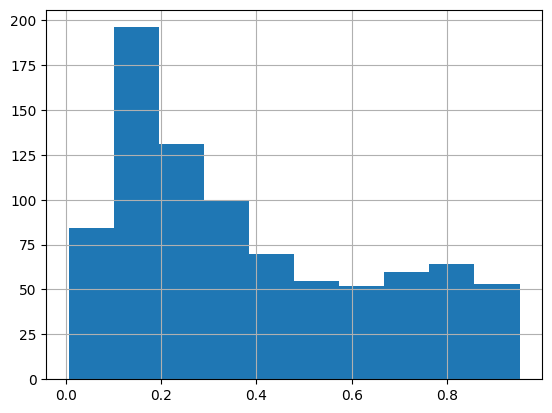

In [49]:
census_demos['Percent: 25+ Bachelor\'s Degree or More'].hist()


In [54]:
difference_row.to_csv('../../can-summer-2023/notebooks/CSV\'S THINGS /difference_row.csv')